In [1]:
# Importing necessary libraries
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical, img_to_array
import tensorflow as tf
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Checking TensorFlow version for compatibility
tf_version = int(tf.__version__.split(".", maxsplit=1)[0])
assert tf_version >= 2, "This script requires TensorFlow 2.x"



In [2]:

# pre-processing functions
def preprocess_image(image_path, size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)
    return img_to_array(img) / 255.0

def parse_labels(filename):
    parts = os.path.basename(filename).split("_")
    if len(parts) < 3:
        return None
    return int(parts[0]), int(parts[1]), int(parts[2])

def data_generator(file_paths, batch_size, preprocess_fn, label_fn):
    while True:
        batch_paths = np.random.choice(a=file_paths, size=batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            labels = label_fn(input_path)
            if labels is None:
                continue
            image = preprocess_fn(input_path)
            batch_input.append(image)
            batch_output.append(labels)

        yield np.array(batch_input, dtype='float32'), np.array(batch_output)

race_mapping = {
    0: "White",
    1: "Black",
    2: "Asian",
    3: "Indian",
    4: "Others"
}


In [3]:
# Data Preparation
images_directory = 'E:/capJC/paper/part1'  
img_paths = glob(os.path.join(images_directory, "*.jpg"))

# Splitting dataset into training, validation, and testing
train_paths, test_paths = train_test_split(img_paths, test_size=0.45, random_state=42)
valid_paths, test_paths = train_test_split(test_paths, test_size=(20/45), random_state=42)  

# Define batch size
batch_size = 128  # i.e. no. of images that is gonna be processed, at one time


In [4]:
import os

def extract_labels_from_filename(filename, trashy_file='trashy.csv'):
    try:
        parts = os.path.basename(filename).split('_')
        if len(parts) < 4 or not parts[0].isdigit() or not parts[1] in ['0', '1'] or not parts[2].isdigit():
            raise ValueError("Invalid filename format")

        age = int(parts[0])
        gender = int(parts[1])  # 0 for male; 1 for female
        race = int(parts[2])  # Assuming integer labels for races
        return age, gender, race
    except ValueError as e:
        with open(trashy_file, 'a') as file:
            file.write(filename + '\n')
        print(f"Error processing file {filename}: {e}")
        return None, None, None  



In [5]:
# Age Model
age_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, name='age_output')
])
age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Gender Model
gender_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid', name='gender_output')
])
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [6]:
# Race Model
race_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(race_mapping), activation='softmax', name='race_output')
])
race_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
def train_age_generator(train_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=train_paths, size=batch_size)
        batch_images = []
        batch_ages = []

        for file_path in batch_paths:
            age, _, _ = extract_labels_from_filename(os.path.basename(file_path))
            if age is None:
                continue  # Skip this file if age is None
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_ages.append(age)

        yield np.array(batch_images), np.array(batch_ages)

def valid_age_generator(valid_paths, batch_size):
    while True:
        batch_paths = np.random.choice(a=valid_paths, size=batch_size)
        batch_images = []
        batch_ages = []

        for file_path in batch_paths:
            age, _, _ = extract_labels_from_filename(os.path.basename(file_path))
            if age is None:
                continue  # Skip this file if age is None
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_ages.append(age)

        yield np.array(batch_images), np.array(batch_ages)


In [8]:
def train_gender_generator(train_paths, batch_size):
    while True:
        batch_images = []
        batch_genders = []

        for file_path in np.random.choice(train_paths, size=batch_size):
            _, gender, _ = extract_labels_from_filename(os.path.basename(file_path))
            if gender is None:
                continue  # Skip this file if gender is None
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_genders.append(gender)

        yield np.array(batch_images), np.array(batch_genders)



def valid_gender_generator(valid_paths, batch_size):
    while True:
        batch_images = []
        batch_genders = []

        for file_path in np.random.choice(a=valid_paths, size=batch_size):
            _, gender, _ = extract_labels_from_filename(os.path.basename(file_path))
            if gender is None:
                continue  
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_genders.append(gender)

        yield np.array(batch_images), np.array(batch_genders)



In [9]:
def train_race_generator(train_paths, batch_size):
    while True:
        batch_images = []
        batch_races = []

        for file_path in np.random.choice(a=train_paths, size=batch_size):
            _, _, race = extract_labels_from_filename(os.path.basename(file_path))
            if race is None:
                continue  # Skip this file if race is None
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_races.append(to_categorical(race, num_classes=len(race_mapping)))

        yield np.array(batch_images), np.array(batch_races)


def valid_race_generator(valid_paths, batch_size):
    while True:
        batch_images = []
        batch_races = []

        for file_path in np.random.choice(a=valid_paths, size=batch_size):
            _, _, race = extract_labels_from_filename(os.path.basename(file_path))
            if race is None:
                continue  # Skip this file if race is None
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_races.append(to_categorical(race, num_classes=len(race_mapping)))

        yield np.array(batch_images), np.array(batch_races)


In [10]:

# Corrected way to instantiate the generators
age_train_generator = train_age_generator(train_paths, batch_size)
age_valid_generator = valid_age_generator(valid_paths, batch_size)

gender_train_generator = train_gender_generator(train_paths, batch_size)
gender_valid_generator = valid_gender_generator(valid_paths, batch_size)

race_train_generator = train_race_generator(train_paths, batch_size)
race_valid_generator = valid_race_generator(valid_paths, batch_size)

# Training Age Model
history_age = age_model.fit(
    age_train_generator,
    steps_per_epoch=len(train_paths) // batch_size, 
    epochs=10,
    validation_data=age_valid_generator,
    validation_steps=len(valid_paths) // batch_size
)

# Training Gender Model
history_gender = gender_model.fit(
    gender_train_generator,
    steps_per_epoch=len(train_paths) // batch_size, 
    epochs=10,
    validation_data=gender_valid_generator,
    validation_steps=len(valid_paths) // batch_size
)

# Training Race Model
history_race = race_model.fit(
    race_train_generator,
    steps_per_epoch=len(train_paths) // batch_size, 
    epochs=10,
    validation_data=race_valid_generator,
    validation_steps=len(valid_paths) // batch_size
)


Epoch 1/10


103/103 [==============================] - ETA: 0s - loss: 623.2198 - mae: 18.7007Error processing file 61_1_20170109142408075.jpg: Invalid filename format
Error processing file 61_1_20170109142408075.jpg: Invalid filename format
Error processing file 61_1_20170109142408075.jpg: Invalid filename format
Error processing file 61_1_20170109142408075.jpg: Invalid filename format
103/103 [==============================] - 216s 2s/step - loss: 623.2198 - mae: 18.7007 - val_loss: 394.0562 - val_mae: 14.8465
Epoch 2/10
103/103 [==============================] - 213s 2s/step - loss: 358.4850 - mae: 14.6153 - val_loss: 340.6069 - val_mae: 14.3215
Epoch 3/10
103/103 [==============================] - ETA: 0s - loss: 322.0810 - mae: 13.8798Error processing file 53__0_20170116184028385.jpg: Invalid filename format
Error processing file 61_1_20170109142408075.jpg: Invalid filename format
Error processing file 61_1_20170109142408075.jpg: Invalid filename format
Error processing file 61_1

In [11]:
def test_age_generator_debug(test_paths, batch_size):
    batch_paths = test_paths[:batch_size]
    batch_images = []
    batch_ages = []

    for file_path in batch_paths:
        result = extract_labels_from_filename(file_path)
        if result:
            age, _, _ = result
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_ages.append(age)

    batch_images_np = np.array(batch_images)
    batch_ages_np = np.array(batch_ages)

    print("Batch Images Shape:", batch_images_np.shape)
    print("Batch Ages Shape:", batch_ages_np.shape)

    yield batch_images_np, batch_ages_np

# debug generator:
age_test_generator_debug = test_age_generator_debug(test_paths, batch_size)
age_test_loss, age_test_mae = age_model.evaluate(age_test_generator_debug, steps=1)


Batch Images Shape: (128, 224, 224, 3)
Batch Ages Shape: (128,)
1/1 [==============================] - 1s 979ms/step - loss: 316.3598 - mae: 13.4198


In [12]:
def test_gender_generator_debug(test_paths, batch_size):
    batch_paths = test_paths[:batch_size]
    batch_images = []
    batch_genders = []

    for file_path in batch_paths:
        result = extract_labels_from_filename(file_path)
        if result:
            _, gender, _ = result
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_genders.append(gender)

    batch_images_np = np.array(batch_images)
    batch_genders_np = np.array(batch_genders)

    print("Batch Images Shape:", batch_images_np.shape)
    print("Batch Genders Shape:", batch_genders_np.shape)
    print("Batch Genders Type:", batch_genders_np.dtype)

    yield batch_images_np, batch_genders_np

# Use the debug generator
gender_test_generator_debug = test_gender_generator_debug(test_paths, batch_size)
gender_test_loss, gender_test_accuracy = gender_model.evaluate(gender_test_generator_debug, steps=1)



Batch Images Shape: (128, 224, 224, 3)
Batch Genders Shape: (128,)
Batch Genders Type: int32
1/1 [==============================] - 1s 501ms/step - loss: 1.1151 - accuracy: 0.6875


In [13]:
def test_race_generator_debug(test_paths, batch_size):
    batch_paths = test_paths[:batch_size]
    batch_images = []
    batch_races = []

    for file_path in batch_paths:
        result = extract_labels_from_filename(file_path)
        if result:
            _, _, race = result
            image = preprocess_image(file_path)
            batch_images.append(image)
            batch_races.append(to_categorical(race, num_classes=len(race_mapping)))

    batch_images_np = np.array(batch_images)
    batch_races_np = np.array(batch_races)

    print("Batch Images Shape:", batch_images_np.shape)
    print("Batch Races Shape:", batch_races_np.shape)
    print("Batch Races Type:", batch_races_np.dtype)

    yield batch_images_np, batch_races_np

# Use the debug generator
race_test_generator_debug = test_race_generator_debug(test_paths, batch_size)
race_test_loss, race_test_accuracy = race_model.evaluate(race_test_generator_debug, steps=1)


Batch Images Shape: (128, 224, 224, 3)
Batch Races Shape: (128, 5)
Batch Races Type: float32
1/1 [==============================] - 0s 293ms/step - loss: 2.4971 - accuracy: 0.4062


Evaluating Age Model:   0%|          | 0/38 [00:00<?, ?it/s]

4/4 [==============================] - 0s 74ms/step


Evaluating Age Model:   3%|▎         | 1/38 [00:01<00:46,  1.27s/it]

4/4 [==============================] - 0s 69ms/step


Evaluating Age Model:   5%|▌         | 2/38 [00:02<00:47,  1.33s/it]

4/4 [==============================] - 0s 74ms/step


Evaluating Age Model:   8%|▊         | 3/38 [00:03<00:44,  1.28s/it]

4/4 [==============================] - 0s 72ms/step


Evaluating Age Model:  11%|█         | 4/38 [00:04<00:39,  1.15s/it]

4/4 [==============================] - 0s 74ms/step


Evaluating Age Model:  13%|█▎        | 5/38 [00:05<00:36,  1.09s/it]

4/4 [==============================] - 0s 66ms/step


Evaluating Age Model:  16%|█▌        | 6/38 [00:07<00:37,  1.19s/it]

4/4 [==============================] - 0s 63ms/step


Evaluating Age Model:  18%|█▊        | 7/38 [00:08<00:41,  1.33s/it]

4/4 [==============================] - 0s 81ms/step


Evaluating Age Model:  21%|██        | 8/38 [00:09<00:36,  1.22s/it]

4/4 [==============================] - 0s 57ms/step


Evaluating Age Model:  24%|██▎       | 9/38 [00:10<00:31,  1.10s/it]

Error processing file E:/capJC/paper/part1\61_3_20170109150557335.jpg: Invalid filename format
4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  26%|██▋       | 10/38 [00:11<00:31,  1.13s/it]

4/4 [==============================] - 0s 60ms/step


Evaluating Age Model:  29%|██▉       | 11/38 [00:12<00:30,  1.12s/it]

4/4 [==============================] - 0s 68ms/step


Evaluating Age Model:  32%|███▏      | 12/38 [00:13<00:27,  1.07s/it]

4/4 [==============================] - 0s 57ms/step


Evaluating Age Model:  34%|███▍      | 13/38 [00:14<00:25,  1.03s/it]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  37%|███▋      | 14/38 [00:15<00:25,  1.07s/it]

4/4 [==============================] - 0s 65ms/step


Evaluating Age Model:  39%|███▉      | 15/38 [00:17<00:24,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


Evaluating Age Model:  42%|████▏     | 16/38 [00:18<00:23,  1.06s/it]

Error processing file E:/capJC/paper/part1\39_1_20170116174525125.jpg: Invalid filename format
4/4 [==============================] - 0s 67ms/step


Evaluating Age Model:  45%|████▍     | 17/38 [00:19<00:21,  1.04s/it]

4/4 [==============================] - 0s 64ms/step


Evaluating Age Model:  47%|████▋     | 18/38 [00:20<00:21,  1.07s/it]

4/4 [==============================] - 0s 70ms/step


Evaluating Age Model:  50%|█████     | 19/38 [00:21<00:19,  1.04s/it]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  53%|█████▎    | 20/38 [00:22<00:18,  1.05s/it]

4/4 [==============================] - 0s 59ms/step


Evaluating Age Model:  55%|█████▌    | 21/38 [00:23<00:17,  1.02s/it]

4/4 [==============================] - 0s 59ms/step


Evaluating Age Model:  58%|█████▊    | 22/38 [00:24<00:17,  1.08s/it]

4/4 [==============================] - 0s 58ms/step


Evaluating Age Model:  61%|██████    | 23/38 [00:25<00:16,  1.10s/it]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  63%|██████▎   | 24/38 [00:26<00:15,  1.08s/it]

4/4 [==============================] - 0s 58ms/step


Evaluating Age Model:  66%|██████▌   | 25/38 [00:27<00:13,  1.03s/it]

4/4 [==============================] - 0s 62ms/step


Evaluating Age Model:  68%|██████▊   | 26/38 [00:28<00:12,  1.06s/it]

4/4 [==============================] - 0s 63ms/step


Evaluating Age Model:  71%|███████   | 27/38 [00:29<00:10,  1.00it/s]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  74%|███████▎  | 28/38 [00:30<00:10,  1.02s/it]

4/4 [==============================] - 0s 57ms/step


Evaluating Age Model:  76%|███████▋  | 29/38 [00:31<00:08,  1.02it/s]

4/4 [==============================] - 0s 69ms/step


Evaluating Age Model:  79%|███████▉  | 30/38 [00:32<00:08,  1.00s/it]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  82%|████████▏ | 31/38 [00:33<00:07,  1.02s/it]

4/4 [==============================] - 0s 63ms/step


Evaluating Age Model:  84%|████████▍ | 32/38 [00:34<00:06,  1.03s/it]

4/4 [==============================] - 0s 61ms/step


Evaluating Age Model:  87%|████████▋ | 33/38 [00:35<00:05,  1.00s/it]

4/4 [==============================] - 0s 56ms/step


Evaluating Age Model:  89%|████████▉ | 34/38 [00:36<00:03,  1.03it/s]

4/4 [==============================] - 0s 67ms/step


Evaluating Age Model:  92%|█████████▏| 35/38 [00:37<00:03,  1.01s/it]

4/4 [==============================] - 0s 55ms/step


Evaluating Age Model:  95%|█████████▍| 36/38 [00:38<00:01,  1.01it/s]

4/4 [==============================] - 0s 62ms/step


Evaluating Age Model:  97%|█████████▋| 37/38 [00:39<00:00,  1.03it/s]

3/3 [==============================] - 0s 56ms/step


Evaluating Age Model: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]

Age Model MAE: 14.189058303931937


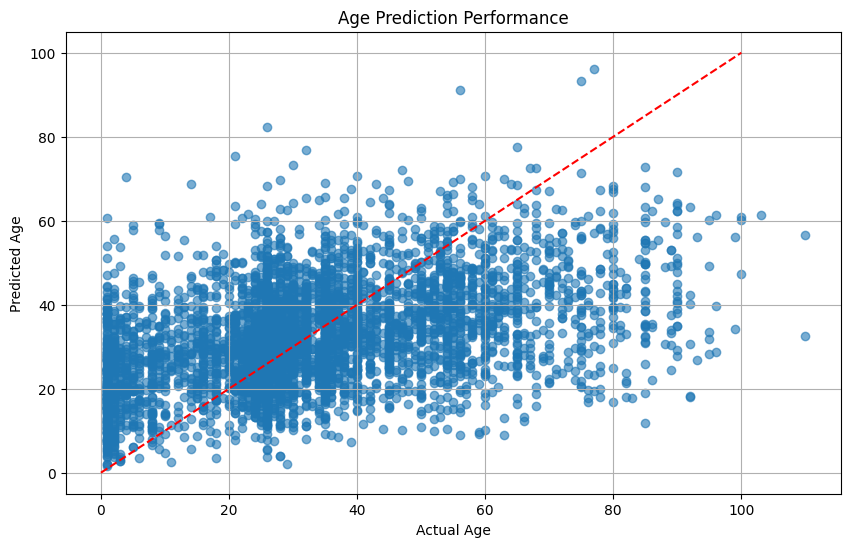

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm


def evaluate_age_model(test_paths, age_model, batch_size):
    actual_ages = []
    predicted_ages = []
    try:
        for i in tqdm(range(0, len(test_paths), batch_size), desc='Evaluating Age Model'):
            batch_paths = test_paths[i:i+batch_size]
            batch_images = []
            batch_labels = []
            for path in batch_paths:
                result = extract_labels_from_filename(path)
                if result:
                    age, _, _ = result
                    if age is not None:  
                        image = preprocess_image(path)
                        batch_images.append(image)
                        batch_labels.append(age)
            if batch_images:
                batch_images_np = np.array(batch_images)
                predictions = age_model.predict(batch_images_np)
                predicted_ages_batch = np.squeeze(predictions).tolist()
                
                if isinstance(predicted_ages_batch, float):
                    predicted_ages.append(predicted_ages_batch)
                else:
                    predicted_ages.extend(predicted_ages_batch)
                actual_ages.extend(batch_labels)
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

    return actual_ages, [pred if pred is not None else np.nan for pred in predicted_ages]  

actual_ages, predicted_ages = evaluate_age_model(test_paths, age_model, batch_size)

if all(age is not None for age in actual_ages) and all(age is not None for age in predicted_ages):
    try:
        age_mae = mean_absolute_error(actual_ages, predicted_ages)
        print("Age Model MAE:", age_mae)

        # Plotting the age predictions
        plt.figure(figsize=(10, 6))
        plt.scatter(actual_ages, predicted_ages, alpha=0.6)
        plt.plot([0, 100], [0, 100], 'r--')  # Ideal line where predicted age==actual age
        plt.xlabel('Actual Age')
        plt.ylabel('Predicted Age')
        plt.title('Age Prediction Performance')
        plt.grid(True)
        plt.show()
    except ValueError as e:
        print(f"ValueError: {e}")
else:
    print("Data contains None values which cannot be processed.")



Evaluating Gender Model:   0%|          | 0/38 [00:00<?, ?it/s]

4/4 [==============================] - 0s 79ms/step


Evaluating Gender Model:   3%|▎         | 1/38 [00:01<00:42,  1.15s/it]

4/4 [==============================] - 0s 85ms/step


Evaluating Gender Model:   5%|▌         | 2/38 [00:02<00:45,  1.28s/it]

4/4 [==============================] - 0s 81ms/step


Evaluating Gender Model:   8%|▊         | 3/38 [00:03<00:45,  1.31s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Gender Model:  11%|█         | 4/38 [00:04<00:40,  1.20s/it]

4/4 [==============================] - 0s 90ms/step


Evaluating Gender Model:  13%|█▎        | 5/38 [00:05<00:38,  1.16s/it]

4/4 [==============================] - 0s 75ms/step


Evaluating Gender Model:  16%|█▌        | 6/38 [00:07<00:39,  1.24s/it]

4/4 [==============================] - 0s 85ms/step


Evaluating Gender Model:  18%|█▊        | 7/38 [00:09<00:44,  1.43s/it]

4/4 [==============================] - 0s 85ms/step


Evaluating Gender Model:  21%|██        | 8/38 [00:10<00:39,  1.32s/it]

4/4 [==============================] - 0s 93ms/step


Evaluating Gender Model:  24%|██▎       | 9/38 [00:11<00:35,  1.22s/it]

Error processing file E:/capJC/paper/part1\61_3_20170109150557335.jpg: Invalid filename format
4/4 [==============================] - 0s 72ms/step


Evaluating Gender Model:  26%|██▋       | 10/38 [00:12<00:33,  1.20s/it]

4/4 [==============================] - 0s 79ms/step


Evaluating Gender Model:  29%|██▉       | 11/38 [00:13<00:32,  1.21s/it]

4/4 [==============================] - 0s 74ms/step


Evaluating Gender Model:  32%|███▏      | 12/38 [00:14<00:29,  1.15s/it]

4/4 [==============================] - 0s 90ms/step


Evaluating Gender Model:  34%|███▍      | 13/38 [00:15<00:28,  1.13s/it]

4/4 [==============================] - 0s 73ms/step


Evaluating Gender Model:  37%|███▋      | 14/38 [00:17<00:27,  1.16s/it]

4/4 [==============================] - 0s 76ms/step


Evaluating Gender Model:  39%|███▉      | 15/38 [00:18<00:27,  1.19s/it]

4/4 [==============================] - 0s 76ms/step


Evaluating Gender Model:  42%|████▏     | 16/38 [00:19<00:25,  1.16s/it]

Error processing file E:/capJC/paper/part1\39_1_20170116174525125.jpg: Invalid filename format
4/4 [==============================] - 0s 77ms/step


Evaluating Gender Model:  45%|████▍     | 17/38 [00:20<00:23,  1.14s/it]

4/4 [==============================] - 0s 79ms/step


Evaluating Gender Model:  47%|████▋     | 18/38 [00:21<00:23,  1.16s/it]

4/4 [==============================] - 0s 77ms/step


Evaluating Gender Model:  50%|█████     | 19/38 [00:22<00:21,  1.14s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Gender Model:  53%|█████▎    | 20/38 [00:23<00:20,  1.16s/it]

4/4 [==============================] - 0s 90ms/step


Evaluating Gender Model:  55%|█████▌    | 21/38 [00:25<00:19,  1.15s/it]

4/4 [==============================] - 0s 75ms/step


Evaluating Gender Model:  58%|█████▊    | 22/38 [00:26<00:19,  1.20s/it]

4/4 [==============================] - 0s 88ms/step


Evaluating Gender Model:  61%|██████    | 23/38 [00:27<00:18,  1.24s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Gender Model:  63%|██████▎   | 24/38 [00:28<00:17,  1.23s/it]

4/4 [==============================] - 0s 75ms/step


Evaluating Gender Model:  66%|██████▌   | 25/38 [00:29<00:14,  1.14s/it]

4/4 [==============================] - 0s 105ms/step


Evaluating Gender Model:  68%|██████▊   | 26/38 [00:31<00:14,  1.22s/it]

4/4 [==============================] - 0s 91ms/step


Evaluating Gender Model:  71%|███████   | 27/38 [00:32<00:13,  1.19s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Gender Model:  74%|███████▎  | 28/38 [00:33<00:12,  1.21s/it]

4/4 [==============================] - 0s 82ms/step


Evaluating Gender Model:  76%|███████▋  | 29/38 [00:34<00:10,  1.13s/it]

4/4 [==============================] - 0s 95ms/step


Evaluating Gender Model:  79%|███████▉  | 30/38 [00:35<00:09,  1.16s/it]

4/4 [==============================] - 0s 80ms/step


Evaluating Gender Model:  82%|████████▏ | 31/38 [00:36<00:08,  1.16s/it]

4/4 [==============================] - 0s 89ms/step


Evaluating Gender Model:  84%|████████▍ | 32/38 [00:38<00:07,  1.19s/it]

4/4 [==============================] - 0s 82ms/step


Evaluating Gender Model:  87%|████████▋ | 33/38 [00:39<00:05,  1.15s/it]

4/4 [==============================] - 0s 92ms/step


Evaluating Gender Model:  89%|████████▉ | 34/38 [00:40<00:04,  1.14s/it]

4/4 [==============================] - 0s 92ms/step


Evaluating Gender Model:  92%|█████████▏| 35/38 [00:41<00:03,  1.20s/it]

4/4 [==============================] - 0s 92ms/step


Evaluating Gender Model:  95%|█████████▍| 36/38 [00:42<00:02,  1.18s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Gender Model:  97%|█████████▋| 37/38 [00:43<00:01,  1.14s/it]

3/3 [==============================] - 0s 69ms/step


Evaluating Gender Model: 100%|██████████| 38/38 [00:44<00:00,  1.18s/it]

Gender Model Accuracy: 0.6850622406639004


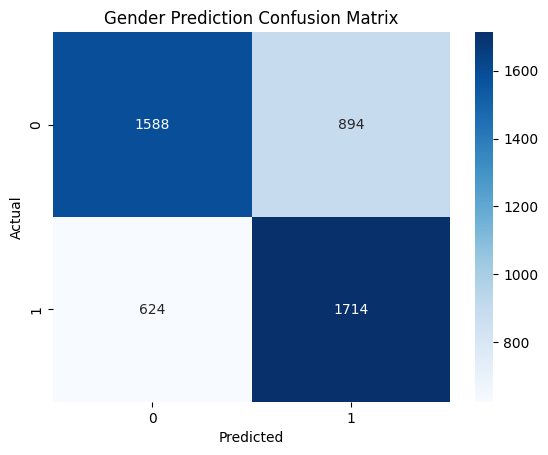

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm



def evaluate_gender_model(test_paths, gender_model, batch_size):
    actual_genders = []
    predicted_genders = []
    try:
        for i in tqdm(range(0, len(test_paths), batch_size), desc='Evaluating Gender Model'):
            batch_paths = test_paths[i:i+batch_size]
            batch_images = []
            batch_labels = []
            for path in batch_paths:
                result = extract_labels_from_filename(path)
                if result:
                    _, gender, _ = result
                    if gender in [0, 1]:  # Ensure gender is binary
                        image = preprocess_image(path)
                        batch_images.append(image)
                        batch_labels.append(gender)
            if batch_images:
                batch_images_np = np.array(batch_images)
                predicted_genders_batch = gender_model.predict(batch_images_np).squeeze()
                predicted_genders.extend([int(prob > 0.5) for prob in predicted_genders_batch])
                actual_genders.extend(batch_labels)
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

    return actual_genders, predicted_genders

actual_genders, predicted_genders = evaluate_gender_model(test_paths, gender_model, batch_size)

# Ensure the lists only contain binary values
if all(gender in [0, 1] for gender in actual_genders + predicted_genders):
    try:
        gender_accuracy = accuracy_score(actual_genders, predicted_genders)
        print("Gender Model Accuracy:", gender_accuracy)

        conf_matrix = confusion_matrix(actual_genders, predicted_genders)
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Gender Prediction Confusion Matrix')
        plt.show()
    except ValueError as e:
        print(f"ValueError: {e}")
else:
    print("Data contains invalid values (not binary).")



Evaluating Race Model:   0%|          | 0/38 [00:00<?, ?it/s]

4/4 [==============================] - 0s 89ms/step


Evaluating Race Model:   3%|▎         | 1/38 [00:01<00:41,  1.13s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Race Model:   5%|▌         | 2/38 [00:02<00:46,  1.29s/it]

4/4 [==============================] - 0s 86ms/step


Evaluating Race Model:   8%|▊         | 3/38 [00:03<00:44,  1.26s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  11%|█         | 4/38 [00:04<00:38,  1.14s/it]

4/4 [==============================] - 0s 92ms/step


Evaluating Race Model:  13%|█▎        | 5/38 [00:05<00:35,  1.08s/it]

4/4 [==============================] - 0s 80ms/step


Evaluating Race Model:  16%|█▌        | 6/38 [00:07<00:38,  1.19s/it]

4/4 [==============================] - 0s 90ms/step


Evaluating Race Model:  18%|█▊        | 7/38 [00:08<00:43,  1.39s/it]

4/4 [==============================] - 0s 90ms/step


Evaluating Race Model:  21%|██        | 8/38 [00:09<00:38,  1.29s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  24%|██▎       | 9/38 [00:10<00:34,  1.18s/it]

Error processing file E:/capJC/paper/part1\61_3_20170109150557335.jpg: Invalid filename format
4/4 [==============================] - 0s 94ms/step


Evaluating Race Model:  26%|██▋       | 10/38 [00:12<00:34,  1.22s/it]

4/4 [==============================] - 0s 93ms/step


Evaluating Race Model:  29%|██▉       | 11/38 [00:13<00:33,  1.23s/it]

4/4 [==============================] - 0s 81ms/step


Evaluating Race Model:  32%|███▏      | 12/38 [00:14<00:30,  1.15s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Race Model:  34%|███▍      | 13/38 [00:15<00:27,  1.12s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  37%|███▋      | 14/38 [00:16<00:27,  1.15s/it]

4/4 [==============================] - 0s 91ms/step


Evaluating Race Model:  39%|███▉      | 15/38 [00:17<00:26,  1.15s/it]

4/4 [==============================] - 0s 80ms/step


Evaluating Race Model:  42%|████▏     | 16/38 [00:18<00:24,  1.13s/it]

Error processing file E:/capJC/paper/part1\39_1_20170116174525125.jpg: Invalid filename format
4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  45%|████▍     | 17/38 [00:20<00:23,  1.11s/it]

4/4 [==============================] - 0s 79ms/step


Evaluating Race Model:  47%|████▋     | 18/38 [00:21<00:22,  1.12s/it]

4/4 [==============================] - 0s 91ms/step


Evaluating Race Model:  50%|█████     | 19/38 [00:22<00:20,  1.09s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  53%|█████▎    | 20/38 [00:23<00:19,  1.09s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  55%|█████▌    | 21/38 [00:24<00:18,  1.07s/it]

4/4 [==============================] - 0s 82ms/step


Evaluating Race Model:  58%|█████▊    | 22/38 [00:25<00:18,  1.13s/it]

4/4 [==============================] - 0s 86ms/step


Evaluating Race Model:  61%|██████    | 23/38 [00:26<00:17,  1.16s/it]

4/4 [==============================] - 0s 106ms/step


Evaluating Race Model:  63%|██████▎   | 24/38 [00:27<00:16,  1.16s/it]

4/4 [==============================] - 0s 88ms/step


Evaluating Race Model:  66%|██████▌   | 25/38 [00:28<00:14,  1.11s/it]

4/4 [==============================] - 0s 85ms/step


Evaluating Race Model:  68%|██████▊   | 26/38 [00:30<00:13,  1.15s/it]

4/4 [==============================] - 0s 89ms/step


Evaluating Race Model:  71%|███████   | 27/38 [00:31<00:11,  1.09s/it]

4/4 [==============================] - 0s 82ms/step


Evaluating Race Model:  74%|███████▎  | 28/38 [00:32<00:10,  1.09s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Race Model:  76%|███████▋  | 29/38 [00:33<00:09,  1.05s/it]

4/4 [==============================] - 0s 98ms/step


Evaluating Race Model:  79%|███████▉  | 30/38 [00:34<00:08,  1.06s/it]

4/4 [==============================] - 0s 88ms/step


Evaluating Race Model:  82%|████████▏ | 31/38 [00:35<00:07,  1.08s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Race Model:  84%|████████▍ | 32/38 [00:36<00:06,  1.09s/it]

4/4 [==============================] - 0s 82ms/step


Evaluating Race Model:  87%|████████▋ | 33/38 [00:37<00:05,  1.06s/it]

4/4 [==============================] - 0s 76ms/step


Evaluating Race Model:  89%|████████▉ | 34/38 [00:38<00:04,  1.03s/it]

4/4 [==============================] - 0s 83ms/step


Evaluating Race Model:  92%|█████████▏| 35/38 [00:39<00:03,  1.05s/it]

4/4 [==============================] - 0s 102ms/step


Evaluating Race Model:  95%|█████████▍| 36/38 [00:40<00:02,  1.05s/it]

4/4 [==============================] - 0s 87ms/step


Evaluating Race Model:  97%|█████████▋| 37/38 [00:41<00:01,  1.03s/it]

3/3 [==============================] - 0s 76ms/step


Evaluating Race Model: 100%|██████████| 38/38 [00:42<00:00,  1.11s/it]

Race Model Accuracy: 0.4483402489626556


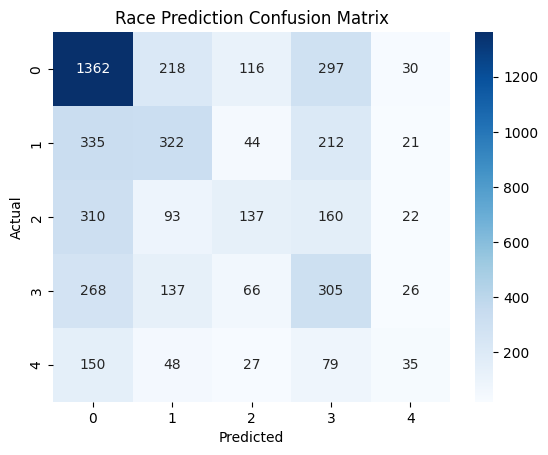

In [16]:

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm



def evaluate_race_model(test_paths, race_model, batch_size):
    actual_races = []
    predicted_races = []
    try:
        for i in tqdm(range(0, len(test_paths), batch_size), desc='Evaluating Race Model'):
            batch_paths = test_paths[i:i+batch_size]
            batch_images = []
            batch_labels = []
            for path in batch_paths:
                result = extract_labels_from_filename(path)
                if result:
                    _, _, race = result
                    if race in range(5):  # Assuming 5 classes for race
                        image = preprocess_image(path)
                        batch_images.append(image)
                        batch_labels.append(race)
            if batch_images:
                batch_images_np = np.array(batch_images)
                predicted_races_batch = race_model.predict(batch_images_np).argmax(axis=-1)
                actual_races.extend(batch_labels)
                predicted_races.extend(predicted_races_batch.tolist())
    except Exception as e:
        print(f"An error occurred: {e}")
        return [], []

    return actual_races, predicted_races

actual_races, predicted_races = evaluate_race_model(test_paths, race_model, batch_size)

if actual_races and predicted_races:
    
    known_labels = set(range(5))  # Assuming 5 classes for race
    if not set(actual_races).issubset(known_labels) or not set(predicted_races).issubset(known_labels):
        print("Unknown labels found.")
    else:
        try:
            race_accuracy = accuracy_score(actual_races, predicted_races)
            print("Race Model Accuracy:", race_accuracy)

            conf_matrix = confusion_matrix(actual_races, predicted_races)
            sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Race Prediction Confusion Matrix')
            plt.show()
        except ValueError as e:
            print(f"ValueError: {e}")
else:
    print("No data to plot or mismatch in the length of actual and predicted lists.")

